In [2]:
import numpy as np 
import pandas as pd 

%matplotlib inline
import matplotlib.pyplot as plt

from cfl.experiment import Experiment 
from sklearn.cluster import KMeans 

# Running CFL on the Data 

In [3]:
# load data 
# data_id = 'questionnaire_hoNOSCA_12' # this data ID indicates the CFL setup with all questionnaire responses at week 0 for the X data and HoNOSCA data at week 12 for the Y data 

data_id = 'questionnaire_hoNOSCA_36' # this data ID indicates the CFL setup with all questionnaire responses at week 0 for the X data and HoNOSCA data at week 36 for the Y data

X = np.load('X_' +data_id+ '.npy')
Y = np.load('Y_' + data_id+ '.npy')

which_week = data_id.split("_")[-1] # this should be "12" or "36"

In [4]:
# the parameters should be passed in dictionary form
data_info = {'X_dims' : X.shape,
             'Y_dims' : Y.shape,
             'Y_type' : 'continuous' #options: 'categorical' or 'continuous'
            }

# pass in empty parameter dictionaries to use the default parameter values (not
# allowed for data_info)
cde_params = {


    
}
cluster_params = {'x_model': KMeans(n_clusters=4), 'y_model': KMeans(n_clusters=2)}

# steps of this CFL pipeline
block_names = ['CondExpMod', 'Clusterer']
block_params = [cde_params, cluster_params]

# folder to save results to
save_path = 'initial_test'

# create the experiment!
my_exp = Experiment(X_train=X, Y_train=Y, data_info=data_info, block_names=block_names, block_params=block_params, results_path=save_path)

All results from this run will be saved to initial_test\experiment0006
batch_size not specified in input, defaulting to 32
n_epochs not specified in input, defaulting to 20
optimizer not specified in input, defaulting to adam
opt_config not specified in input, defaulting to {}
dense_units not specified in input, defaulting to [50, 1]
activations not specified in input, defaulting to ['relu', 'linear']
dropouts not specified in input, defaulting to [0, 0]
weights_path not specified in input, defaulting to None
loss not specified in input, defaulting to mean_squared_error
show_plot not specified in input, defaulting to True
standardize not specified in input, defaulting to False
best not specified in input, defaulting to True
verbose specified but not used by this block type


Training CFL pipeline.
Epoch 1/20
4/4 [==============================] - 5s 1s/step - loss: 3.7861 - val_loss: 0.7610
Epoch 2/20
4/4 [==============================] - 0s 57ms/step - loss: 1.0625 - val_loss: 1.2837
Epoch 3/20
4/4 [==============================] - 0s 39ms/step - loss: 1.4873 - val_loss: 1.1943
Epoch 4/20
4/4 [==============================] - 0s 38ms/step - loss: 1.1274 - val_loss: 0.6292
Epoch 5/20
4/4 [==============================] - 0s 44ms/step - loss: 0.6992 - val_loss: 0.5966
Epoch 6/20
4/4 [==============================] - 0s 40ms/step - loss: 0.7373 - val_loss: 0.6837
Epoch 7/20
4/4 [==============================] - 0s 38ms/step - loss: 0.7853 - val_loss: 0.5750
Epoch 8/20
4/4 [==============================] - 0s 40ms/step - loss: 0.5222 - val_loss: 0.5057
Epoch 9/20
4/4 [==============================] - 0s 36ms/step - loss: 0.5903 - val_loss: 0.5448
Epoch 10/20
4/4 [==============================] - 0s 37ms/step - loss: 0.5659 - val_loss: 0.5293
Epoch 11

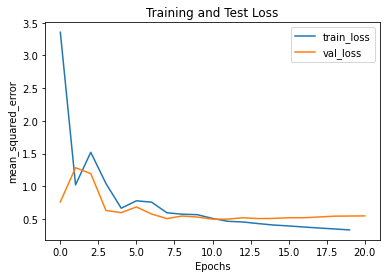

Loading parameters from  tmp_checkpoints/best_weights
Saving parameters to  initial_test\experiment0006\trained_blocks\CondExpMod
100%|██████████| 170/170 [00:00<00:00, 6647.38it/s]


In [5]:
results = my_exp.train()

## CDE Diagnostic: Comparing the CDE prediction of effect distribution with actual distribution

Text(0.5, 1.0, 'Distribution of Predicted Effect Variable from CDE')

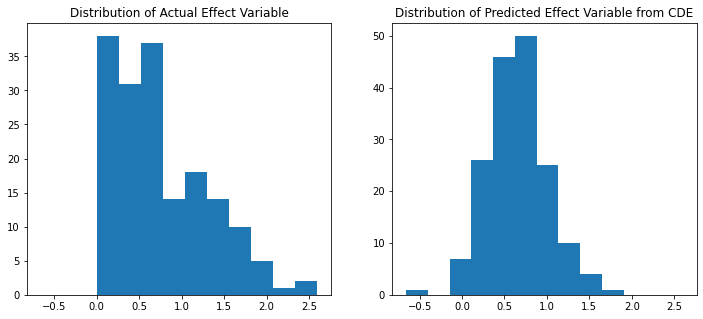

In [5]:
# a test to see how the CDE output is doing 

import matplotlib.pyplot as plt
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(12, 5), sharex=True)

# plot the actual distribution of the effect (HoNOSCA)
axes[0].hist(Y)
axes[0].set_title("Distribution of Actual Effect Variable")

# plot the CDE's predicted distribution of the effect (HoNOSCA) given the input 
axes[1].hist(results['CondExpMod']['pyx'])
axes[1].set_title("Distribution of Predicted Effect Variable from CDE")

# these should ideally look fairly similar if the CDE is doing well 

In [ ]:
# idea: ^ same plots graphed by macro state 

In [6]:
x_lbls = results['Clusterer']['x_lbls']
print("X Macrovariables")
print("---------------------")
for x_macro_class in np.unique(x_lbls): 
    print("the number of samples in macrovariable class {} is {}".format(x_macro_class, np.sum(x_lbls==x_macro_class)))

y_lbls = results['Clusterer']['y_lbls']
print("\nY Macrovariables")
print("---------------------")
for y_macro_class in np.unique(y_lbls): 
    print("the number of samples in macrovariable class {} is {}".format(y_macro_class, np.sum(y_lbls==y_macro_class)))

X Macrovariables
---------------------
the number of samples in macrovariable class 0 is 52
the number of samples in macrovariable class 1 is 16
the number of samples in macrovariable class 2 is 43
the number of samples in macrovariable class 3 is 59

Y Macrovariables
---------------------
the number of samples in macrovariable class 0 is 152
the number of samples in macrovariable class 1 is 18


## Plots to Interpret Results 


In [ ]:
# TODO: make this graph into a function for easy modifying both 

In [87]:
# load the full, original data set for the visualization below
path_to_folder = os.path.join('IMPACT_CausalFeatureLearning', 'Data')

if which_week == '12': 
    # frederick has already cleaned up the data for these two data sets 
    full_data = pd.read_csv(os.path.join(path_to_folder, 'data_w0_12.csv'), engine='python')
elif which_week == '36': 
    full_data = pd.read_csv(os.path.join(path_to_folder, 'data_w0_36.csv'), engine='python')

In [48]:
def add_avg_column(df, column_id, week, macrovar=None, x_lbls=None): 
    '''for adding columns with average or group means to a new 
    data frame
    
    '''
    # only select the rows that correspond to the selected week 
    df = df.loc[df.Time==week]
    
    if macrovar is not None: 
        # only select the rows that correspond to the current macrovar class 
        current_macrovar_indices = np.where(x_lbls == macrovar)[0]
        selected_rows = df.iloc[current_macrovar_indices]
        means = list(selected_rows.mean(axis=0).values)
    else: 
        means = list(df.mean(axis=0).values)

    # create series with column_id as the id and the global means for each column value
    mean_series = pd.Series([column_id] + means[1:], df.columns) 
    return mean_series

In [49]:
x_lbls = results['Clusterer']['x_lbls']

# what is the global mean change (week 12/36 minus week 0) for each questionnaire?

# create a new df with the same columns as the original data set 
avgs_df = full_data.iloc[0:0].copy(deep=True)

# append a new row with the global averages for week 0 to the dataframe
avgs_df = avgs_df.append(add_avg_column(full_data, 'global_avg', 0), ignore_index=True)

# what is the mean value for each question at week 0, for samples in each CFL class ? 
# append a new row with the mean value for each CFL class 
for macrovar in np.unique(x_lbls): 
    name = str(macrovar) + '_avg'
    avgs_df = avgs_df.append(add_avg_column(full_data, name, 0, macrovar=macrovar, x_lbls=x_lbls), ignore_index=True) 

In [67]:
test_types = ['mf', 'rc', 'lo', 'bc']
colors = ['r', 'b', 'g', 'y']
all_test_columns= []
colors_by_col = []

for i in range(len(test_types)): 
    test_type=test_types[i]
    current_color = colors[i]

    # get the columns that contain the current test type 
    curr_tests = [col for col in avgs_df.columns if test_type in col]
    all_test_columns.extend(curr_tests)
    colors_by_col.extend(current_color * len(curr_tests))

Text(0.5, 0.98, 'Global mean-adjusted questionnaire scores, Week 0 and HoNOSCA, week 36')

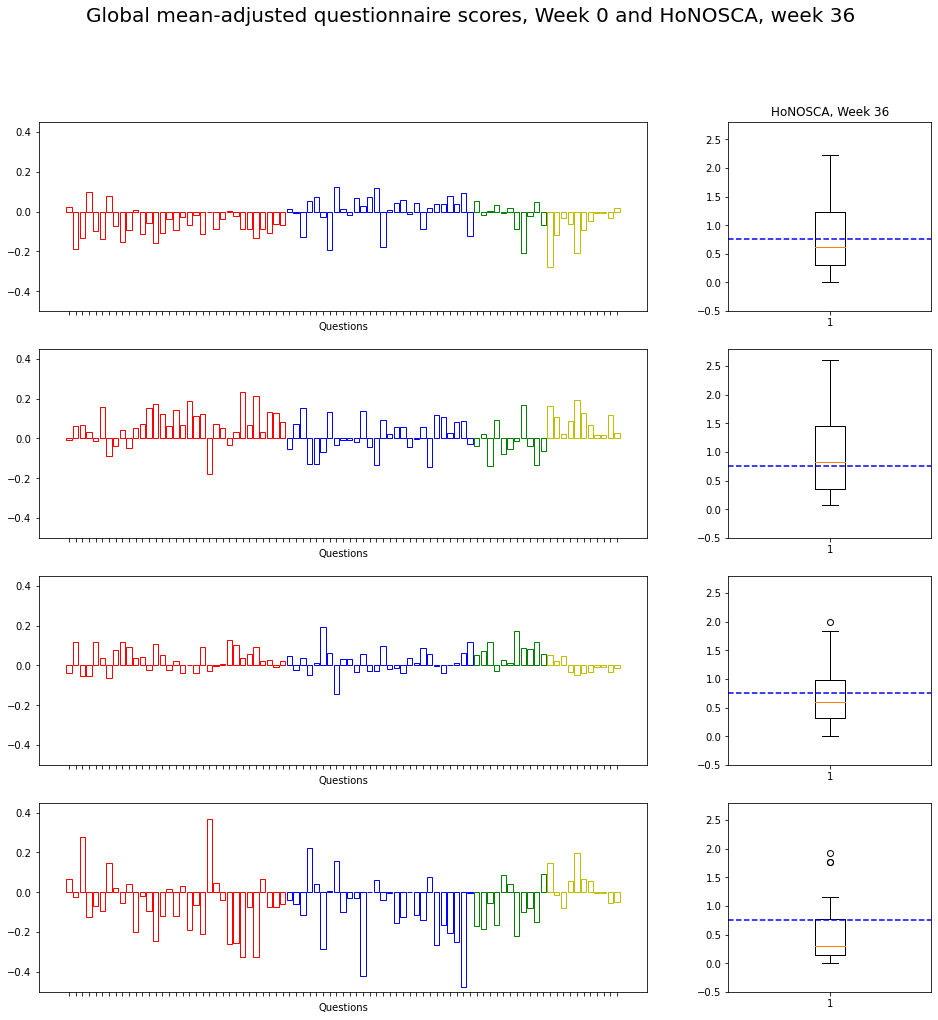

In [75]:
# plot 
fig, axes = plt.subplots(nrows= 4, ncols=2, gridspec_kw={'width_ratios': [3, 1]}, figsize=(16, 16))

# for each macrovariable class: 
for i, ax_row in zip(range(len(np.unique(x_lbls))), axes): 
    
    # get the global average change for the relevant questionnaire
    global_mean= avgs_df.loc[:, all_test_columns].iloc[[0]].values[0]

    # get the mean for that macrovariable
    current_macrovar_mean = avgs_df.loc[:, all_test_columns].iloc[[i+1]].values[0]#skip first row, which contains global avgs

    #subtract the global mean from the mean for the macrovariable 
    global_adj_macrovar_mean = current_macrovar_mean - global_mean
    
    # then add the values to a bar chart 
    ax_row[0].bar(all_test_columns, global_adj_macrovar_mean, edgecolor=colors_by_col, color="None") #manually making sure the same color is associated w same questionnaire each time

    ax_row[0].set_xlabel("Questions")
    ax_row[0].set_xticklabels(labels=[]) # hide axis tick labels

    # create the HoNOSCA BoxPlot
    relevant_honosca_scores = Y[np.where(np.equal(x_lbls, i))]
    ax_row[1].boxplot(relevant_honosca_scores)

    # add a dotted line for the global mean HoNOSCA score
    ax_row[1].axhline(y = np.mean(Y), color = 'b', linestyle = 'dashed', label = "global mean")    

    # set consistent y limits by column
    ax_row[0].set_ylim((-0.5, 0.45))
    ax_row[1].set_ylim((-0.5, 2.8))



axes[0][1].set_title("HoNOSCA, Week 36")
fig.suptitle("Global mean-adjusted questionnaire scores, Week 0 and HoNOSCA, week {}".format(which_week), fontsize=20)


In [78]:
## same graph as above but with only Madison's factors 
madison_factors = ['mf2c', 'mf5c', 'mf6c', 'mf10c', 'mf12c', 'mf13c', 'mf21c', 'mf29c', 'mf16c', 
'mf17c', 'mf18c', 'mf19c', 'mf28c', 'mf31c', 'rc2c', 'rc3c', 'rc6c', 'rc9c', 'rc17c', 'rc21c', 'rc22c',  
'rc26c', 'rc28c', 'lo1c', 'lo3c', 'lo4c', 'lo6c', 'lo7c', 'lo9c', 'lo10c',
'bc1c', 'bc2c', 'bc3c', 'bc4c', 'bc5c', 'bc7c', 'bc10c']


In [104]:
x_lbls = results['Clusterer']['x_lbls']

# create a new df with the same columns as the original data set 
avgs_df = full_data.iloc[0:0].copy(deep=True)

# append a new row with the global averages for week 0 to the dataframe
avgs_df = avgs_df.append(add_avg_column(full_data, 'global_avg', 0), ignore_index=True)

# what is the mean value for each question at week 0, for samples in each CFL class ? 
# append a new row with the mean value for each CFL class 
for macrovar in np.unique(x_lbls): 
    name = str(macrovar) + '_avg'
    avgs_df = avgs_df.append(add_avg_column(full_data, name, 0, macrovar=macrovar, x_lbls=x_lbls), ignore_index=True) 

# drop all columns except Madison's factors and ID 
avgs_df.drop(avgs_df.columns.difference(['id'] + madison_factors), 1, inplace=True)


Text(0.5, 0.98, "Global mean-adjusted questionnaire scores, Week 0 and HoNOSCA, week 36\n (Madison's factors only)")

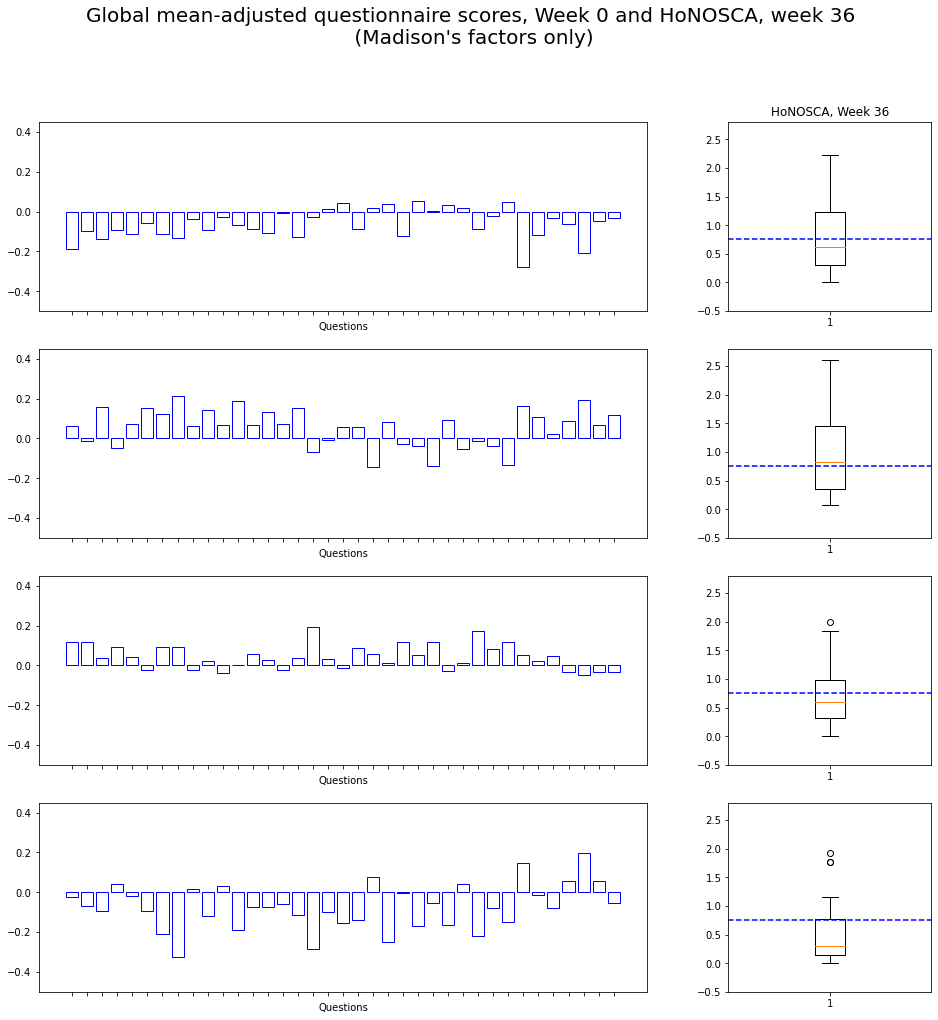

In [107]:
# plot it
fig, axes = plt.subplots(nrows= 4, ncols=2, gridspec_kw={'width_ratios': [3, 1]}, figsize=(16, 16))

# for each macrovariable class: 
for i, ax_row in zip(range(len(np.unique(x_lbls))), axes): 

    # get the global average change for the relevant questionnaire
    global_mean= avgs_df.loc[:, madison_factors].iloc[[0]].values[0]

    # get the mean for that macrovariable
    current_macrovar_mean = avgs_df.loc[:, madison_factors].iloc[[i+1]].values[0]#skip first row, which contains global avgs

    #subtract the global mean from the mean for the macrovariable 
    global_adj_macrovar_mean = current_macrovar_mean - global_mean
    
    # then add the values to a bar chart 
    ax_row[0].bar(madison_factors, global_adj_macrovar_mean, edgecolor='b', color="None") #manually making sure the same color is associated w same questionnaire each time

    ax_row[0].set_xlabel("Questions")
    ax_row[0].set_xticklabels(labels=[]) # hide axis tick labels

    # create the HoNOSCA BoxPlot
    relevant_honosca_scores = Y[np.where(np.equal(x_lbls, i))]
    ax_row[1].boxplot(relevant_honosca_scores)

    # add a dotted line for the global mean HoNOSCA score
    ax_row[1].axhline(y = np.mean(Y), color = 'b', linestyle = 'dashed', label = "global mean")    

    # set consistent y limits by column
    ax_row[0].set_ylim((-0.5, 0.45))
    ax_row[1].set_ylim((-0.5, 2.8))



axes[0][1].set_title("HoNOSCA, Week 36")
fig.suptitle("Global mean-adjusted questionnaire scores, Week 0 and HoNOSCA, week {}\n (Madison's factors only)".format(which_week), fontsize=20)



### next steps: 

tuning # of clusters - sankey diagram (nice to look at)

(stick with kmeans for now )

neural net - not great right now - best kind of CDE for categorical data? 


Visualizing clusters: 
- (we want to see how many members are in each cluster)

first idea: 
- take the spaghetti plots of effect: either make k subplots (for each of k clusters) and graph subjects for each cluster   -- or one subplot with k lines (average value for each member of cluster)
- or the likert diagrams from before to after for each cluster 


Another idea that Cindy will think about 
- see how ecah factor in the paper was determined 
- see if the people in each group load differently for ^these factors (are we grouping people based on how they exhibit these different factors? ) 

- how do people in each CFL cluster score for each of the Aitken factors?




Idea for approach: 
1. Pick one of the weeks (12 or 36)
2. pick a number of clusters (see how many madison chose as a starting point [in paper])
3. set up the pipeline


other thing to check against paper: what (if any) of other information was useful (treatment, sex, location, etc)
- try making a correlation with <vector of everything up until hoNOSCA> and <hoNOSCA> 
^ if sex, etc., has a huge effect, we might see that in this preliminary check 

Text(0.5, 0.98, 'Global mean-adjusted questionnaire scores, Week 0')

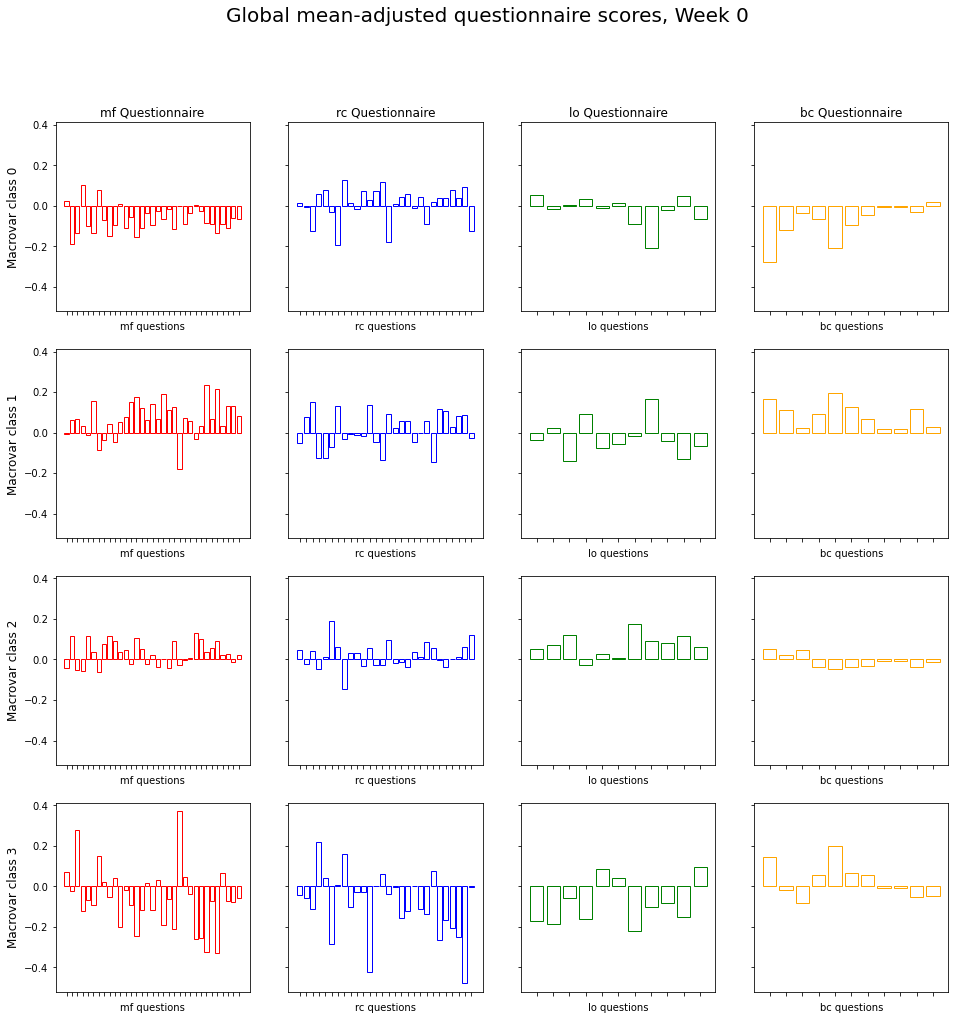

In [19]:
# now graph the difference between the global mean and the averages from each macrovariable class, colored by class 

fig, axes = plt.subplots(nrows=4, ncols=4, figsize=(16, 16), sharey=True)
colors = ['red', 'blue', 'green', 'orange']

firstrow = True
# for each macrovariable class: 
for i, ax_row in zip(range(len(avgs_df))[:-1], axes): 

    # for each questionnaire: 
    for j, ax in zip(range(4), ax_row): 
        test_type = ['mf', 'rc', 'lo', 'bc'][j]

        # get only the columns that contain the current test type 
        test_columns = [col for col in avgs_df.columns if test_type in col]

        # get the global average change for the relevant questionnaire
        global_mean= avgs_df.loc[:, test_columns].iloc[[0]].values[0]

        # get the mean for that macrovariable
        current_macrovar_mean = avgs_df.loc[:, test_columns].iloc[[i+1]].values[0]#skip first row, which contains global avgs

        #subtract the global mean from the mean for the macrovariable 
        global_adj_macrovar_mean = current_macrovar_mean - global_mean
        
        # then add the values to a bar chart 
        ax.bar(test_columns, global_adj_macrovar_mean, edgecolor=colors[j], color="None") #manually making sure the same color is associated w same questionnaire each time

        ax.set_xlabel("{} questions".format(test_type))
        ax.set_xticklabels(labels=[]) # hide axis tick labels

        if firstrow: # set macrovar titles 
            ax_row[j].set_title("{} Questionnaire".format(test_type))


    firstrow=False
    ax_row[0].set_ylabel("Macrovar class {}".format(i), fontsize=12)


# # axes[0].set_ylabel("Change in Avg Scores")
# # axes[2].set_ylabel("Change in Avg Scores")

fig.suptitle("Global mean-adjusted questionnaire scores, Week 0", fontsize=20)


Text(0.5, 0.98, 'Change in HoNOSCA Scores from Week 0 to 36, by Cause Macrovariable Class')

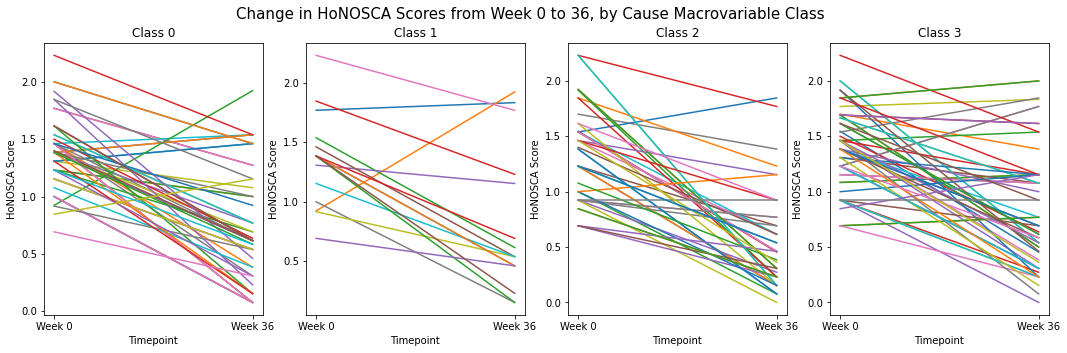

In [23]:
# - take the spaghetti plots of effect: either make k subplots (for each of k clusters) and graph subjects for each cluster   -- or one subplot with k lines (average value for each member of cluster)

timepoints = ['Week 0', 'Week '+ which_week]
num_subplots = len(np.unique(x_lbls))
fig, axes = plt.subplots(1, num_subplots, figsize=(18, 5))

all_ids = full_data["id"].values
for current_macrovar_class, ax in zip(np.unique(x_lbls), axes.flat): 

    # get only the columns that contain the current X macrovariable 
    for i in range(len(x_lbls)): # for all samples.... 

        if x_lbls[i] == current_macrovar_class: 
            current_id = all_ids[i]
            week0_results = full_data.loc[(full_data.id==current_id) & (full_data.Time==0), 'HoNOSCA']
            weekLater_results = full_data.loc[(full_data.id==current_id) & (full_data.Time==int(which_week)), 'HoNOSCA']

        
            ax.plot(timepoints, (week0_results, weekLater_results))
        
        ax.set_title("Class {}".format(current_macrovar_class))
        ax.set_ylabel("HoNOSCA Score")
        ax.set_xlabel("Timepoint")
fig.suptitle("Change in HoNOSCA Scores from Week 0 to {}, by Cause Macrovariable Class".format(which_week), fontsize=15)

### (Sidebar: is the average of questionnaire results a good proxy for HoNOSCA score?)

In [9]:
# grab only the questionnaire results from week 0 
week0_results = full_data.loc[full_data.Time==0].iloc[:, 8:-1]

# grab only the questionnaire results from week 12/36 
weekLater_results = full_data.loc[full_data.Time==int(which_week)].iloc[:, 8:-1]

#average the results across all questions for each timepoint 
week0_average = week0_results.mean(axis=1).values
weekLater_average = weekLater_results.mean(axis=1).values

In [10]:
week0_HoNOSCA = full_data.loc[full_data.Time==0, "HoNOSCA"]
weekLater_HoNOSCA = full_data.loc[full_data.Time==int(which_week), "HoNOSCA"]

In [11]:
np.corrcoef(weekLater_average, weekLater_HoNOSCA)[0, 1]

0.6350730224222482

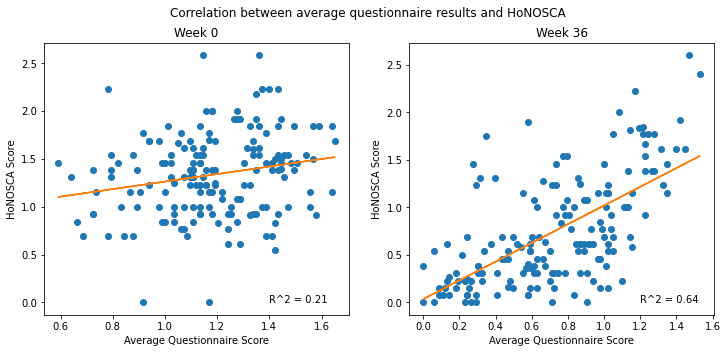

In [22]:
# TODO: check how well HoNOSCA value in week 0 , week 36 is predicted by questionnaire results 

fig, axes = plt.subplots(ncols=2, figsize=(12, 5))

##### Week 0 subplot
# create scatter plot 
axes[0].plot(week0_average, week0_HoNOSCA, 'o')

#obtain m (slope) and b(intercept) of linear regression line
m, b = np.polyfit(week0_average, week0_HoNOSCA, 1)

#add linear regression line to scatterplot 
axes[0].plot(week0_average, m*week0_average+b)

# annotate with R^2 
axes[0].annotate("R^2 = {}".format(np.around(np.corrcoef(week0_average, week0_HoNOSCA)[0,1], 2)), xy=(1.4,0))
axes[0].set_title("Week 0") 

####### Week Later subplot
# create scatter plot 
axes[1].plot(weekLater_average, weekLater_HoNOSCA, 'o')

#obtain m (slope) and b(intercept) of linear regression line
m, b = np.polyfit(weekLater_average, weekLater_HoNOSCA, 1)

#add linear regression line to scatterplot 
axes[1].plot(weekLater_average, m*weekLater_average+b)

# annotate with R^2 
axes[1].annotate("R^2 = {}".format(np.around(np.corrcoef(weekLater_average, weekLater_HoNOSCA)[0,1], 2)), xy=(1.2,0))
axes[1].set_title("Week {}".format(which_week)) 

plt.suptitle("Correlation between average questionnaire results and HoNOSCA")
for ax in axes.flat: 
    ax.set_xlabel("Average Questionnaire Score")
    ax.set_ylabel("HoNOSCA Score")

In [14]:
# for each questionnare: 
# x axis: each question variable 
# subtract global mean for each question 
# plot avg value for representatives from each macrovar class (color by macrovar class)

In [15]:
# temp_df shows the change from week 0 to week 12/36 for each questionnaire question and HoNOSCA

# create a new df with the same columns as the original data set 
temp_df = full_data.iloc[0:0].copy(deep=True)

#drop all the columns we don't need
temp_df = temp_df.drop(['arm', 'sessions', 'age', 'sex', 'region', 'site', 'Time'], axis = 1)  

quest_columns = temp_df.columns[1:] #all the columns corresponding to questionnaire/HoNOSCA results

# fill the df in with the difference at each ID between (week 0 and week-later)
for i in np.unique(full_data.id): # iterate over each subject
    week0 = full_data.loc[(full_data.id==i) & (full_data.Time==0), quest_columns]
    weekLater = full_data.loc[(full_data.id==i) & (full_data.Time==int(which_week)), quest_columns]

    x = weekLater.values - week0.values
    series = pd.Series(np.hstack((i, x[0])), temp_df.columns)
    temp_df = temp_df.append(series, ignore_index=True)

In [16]:
temp_df

,id,mf1c,mf2c,mf3c,mf4c,mf5c,mf6c,mf7c,mf8c,mf9c,...,bc3c,bc4c,bc5c,bc6c,bc7c,bc8c,bc9c,bc10c,bc11c,HoNOSCA
0,1106.0,0.0,0.0,0.0,0.0,0.0,-1.0,0.0,0.0,-1.0,...,-1.0,-1.0,0.0,-1.0,0.0,0.0,0.0,0.0,0.0,-1.076923
1,1107.0,-1.0,-1.0,1.0,-1.0,-2.0,0.0,-2.0,0.0,0.0,...,0.0,0.0,0.0,-1.0,0.0,0.0,0.0,0.0,0.0,-0.923077
2,1110.0,-1.0,1.0,-1.0,1.0,-1.0,0.0,-1.0,0.0,0.0,...,0.0,0.0,-2.0,0.0,0.0,0.0,0.0,0.0,0.0,-1.090909
3,1111.0,-1.0,-1.0,0.0,-1.0,-1.0,-1.0,0.0,-1.0,-1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-0.230769
4,1113.0,0.0,-1.0,0.0,-1.0,1.0,0.0,1.0,-1.0,0.0,...,0.0,0.0,0.0,-1.0,0.0,0.0,0.0,0.0,0.0,0.070513
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
165,3449.0,-1.0,-1.0,-1.0,1.0,-1.0,-2.0,-1.0,-2.0,-2.0,...,0.0,0.0,-1.0,0.0,-1.0,0.0,0.0,0.0,0.0,-2.275641
166,3450.0,-1.0,-2.0,-1.0,0.0,-1.0,-1.0,1.0,-2.0,-1.0,...,0.0,-1.0,-1.0,-1.0,-1.0,0.0,0.0,0.0,-1.0,-1.384615
167,3458.0,-1.0,0.0,-1.0,-1.0,0.0,-1.0,0.0,-2.0,-1.0,...,-2.0,0.0,-1.0,-1.0,-1.0,0.0,-1.0,-1.0,0.0,-1.559441
168,3459.0,-1.0,0.0,0.0,-2.0,0.0,0.0,-1.0,-1.0,0.0,...,0.0,0.0,-1.0,0.0,0.0,0.0,0.0,0.0,0.0,-0.384615


In [18]:
# what is the global mean change (week 12/36 minus week 0) for each questionnaire?

# create a new df with the same columns as the original data set 
avgs_df = temp_df.iloc[0:0].copy(deep=True)

# append a new row with the global averages to the dataframe
avgs_df = avgs_df.append(add_avg_column(temp_df, 'global_avg'), ignore_index=True)

# what is the mean change (week 12/36 minus week 0) for each question, for each samples in each CFL class ? 
# append a new row with the mean change for each CFL class 
for macrovar in np.unique(x_lbls): 
    name = str(macrovar) + '_avg'
    avgs_df = avgs_df.append(add_avg_column(temp_df, name, macrovar=macrovar, x_lbls=x_lbls), ignore_index=True) 

# mean change for each macrovar class - global mean change 


In [19]:
avgs_df

,id,mf1c,mf2c,mf3c,mf4c,mf5c,mf6c,mf7c,mf8c,mf9c,...,bc3c,bc4c,bc5c,bc6c,bc7c,bc8c,bc9c,bc10c,bc11c,HoNOSCA
0,global_avg,-0.747059,-0.658824,-0.452941,0.011765,-0.511765,-0.570588,-0.541176,-0.988235,-0.700000,...,-0.182353,-0.170588,-0.294118,-0.241176,-0.082353,0.000000,-0.005882,-0.041176,-0.041176,-0.585747
1,0_avg,-0.903846,-0.730769,-0.634615,0.096154,-0.519231,-0.615385,-0.692308,-1.019231,-0.961538,...,-0.096154,-0.115385,-0.269231,-0.173077,-0.057692,0.000000,0.000000,0.038462,0.000000,-0.632119
2,1_avg,-0.312500,-0.125000,-0.250000,-0.062500,-0.250000,-0.187500,0.000000,-0.500000,-0.312500,...,-0.312500,-0.375000,-0.437500,-0.125000,0.125000,0.000000,0.000000,-0.125000,0.000000,-0.107758
3,2_avg,-0.906977,-0.860465,-0.627907,-0.046512,-0.813953,-0.558140,-0.674419,-1.116279,-0.767442,...,-0.209302,-0.139535,-0.302326,-0.325581,-0.093023,0.023256,-0.023256,-0.069767,-0.139535,-0.828422
4,3_avg,-0.610169,-0.593220,-0.220339,0.000000,-0.355932,-0.644068,-0.457627,-1.000000,-0.525424,...,-0.203390,-0.186441,-0.271186,-0.271186,-0.152542,-0.016949,0.000000,-0.067797,-0.016949,-0.497635


<ipython-input-27-a81384c14417>:18: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(labels=test_columns,rotation=90)


Text(0.5, 0.98, 'Average global change from Week 0 to Week 36')

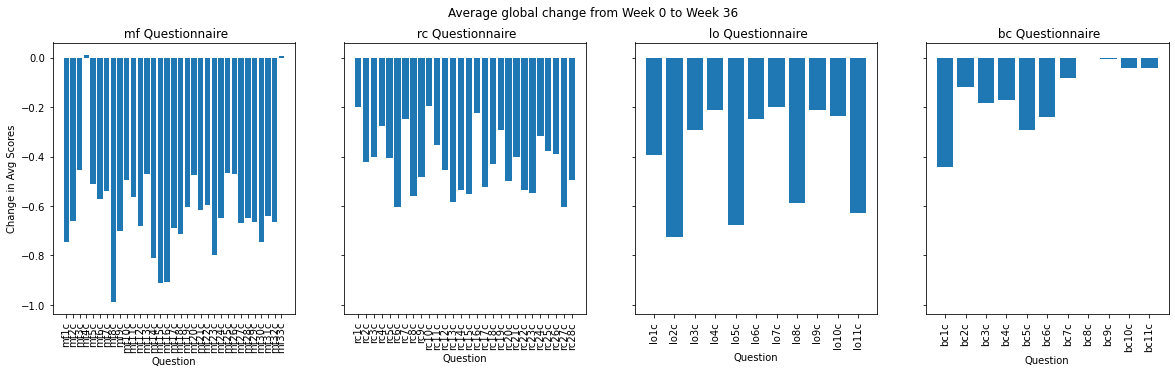

In [27]:
# for each test type:  (mf, rc, lo, bc)
    # graph the change for each question from week 0 to 12/36 

timepoints = ['Week 0', 'Week '+which_week]

fig, axes = plt.subplots(nrows=1, ncols=4, figsize=(20, 5), sharey=True)

for test_type, ax in zip(['mf', 'rc', 'lo', 'bc'], axes.flat): 

    # get only the columns that contain the current test type 
    test_columns = [col for col in temp_df.columns if test_type in col]

    # then make a bar chart for each question 
    ax.bar(test_columns, avgs_df.loc[:, test_columns].iloc[[0]].values[0])

    ax.set_xlabel("Question")
    ax.set_title(" {} Questionnaire".format(test_type))
    ax.set_xticklabels(labels=test_columns,rotation=90) 


axes[0].set_ylabel("Change in Avg Scores")

fig.suptitle("Average global change from Week 0 to Week {}".format(which_week))


Process to generate this graph: 
 
1. Calculate the change from week 0 to week 36 for each participant for each question (week36value - week0value)

2. Average those changes across all participants for each question (this is the GLOBAL MEAN)

3. Average those changes across all participants for each question within each CFL macrovariable class (these are CLASS MEANS)

4. For each CLASS MEAN, subtract out the GLOBAL MEAN for each question 

5. graph results of 4 

Text(0.5, 0.98, 'Global mean adjusted change in questionnaire scores from Week 0 to Week 36')

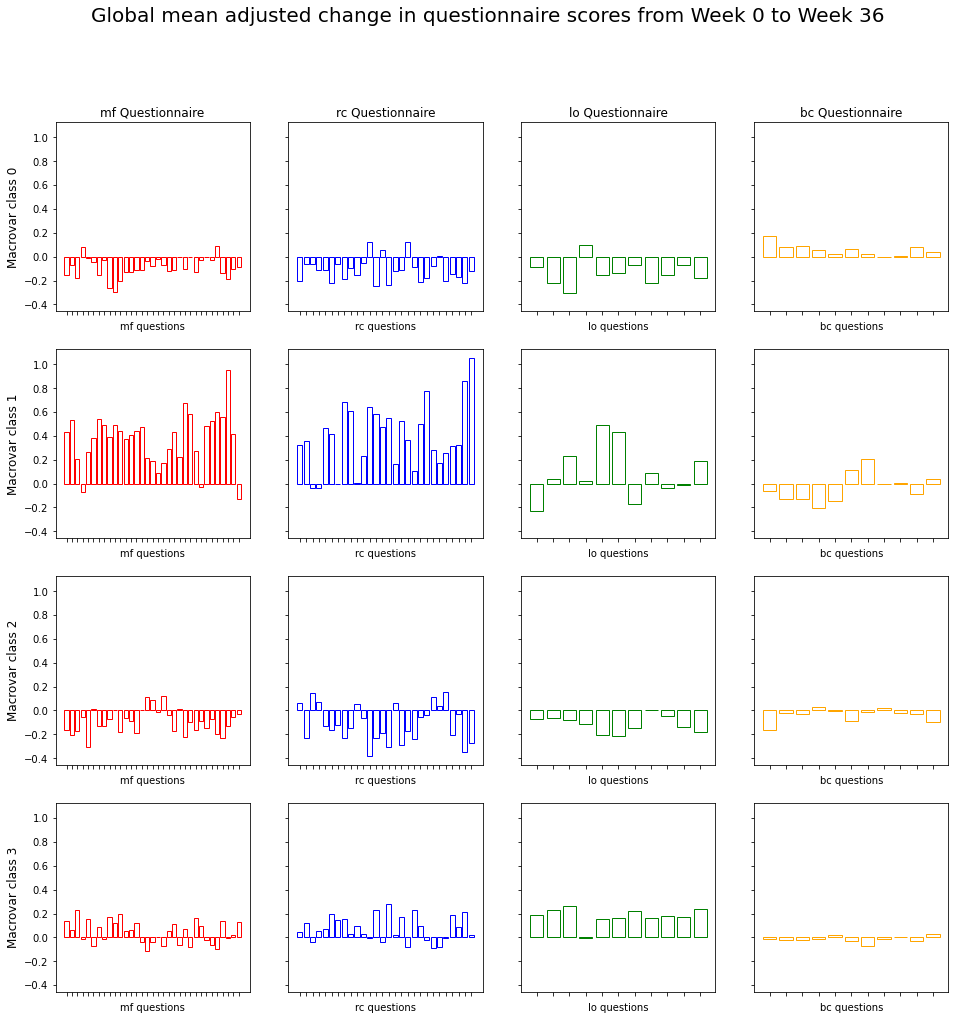

In [76]:
# now graph the difference between the global mean and the averages from each macrovariable class, colored by class 

fig, axes = plt.subplots(nrows=4, ncols=4, figsize=(16, 16), sharey=True)
colors = ['red', 'blue', 'green', 'orange']
firstrow = True

# for each macrovariable class: 
for i, ax_row in zip(range(len(avgs_df))[:-1], axes): 

    # for each questionnaire: 
    for j, ax in zip(range(4), ax_row): 
        test_type = ['mf', 'rc', 'lo', 'bc'][j]

        # get only the columns that contain the current test type 
        test_columns = [col for col in temp_df.columns if test_type in col]

        # get the global average change for the relevant questionnaire
        global_mean= avgs_df.loc[:, test_columns].iloc[[0]].values[0]

        # get the mean for that macrovariable
        current_macrovar_mean = avgs_df.loc[:, test_columns].iloc[[i+1]].values[0]#skip first row, which contains global avgs

        #subtract the global mean from the mean for the macrovariable 
        global_adj_macrovar_mean = current_macrovar_mean - global_mean
        
        # then add the values to a bar chart 
        ax.bar(test_columns, global_adj_macrovar_mean, edgecolor=colors[j], color="None") #manually making sure the same color is associated w same questionnaire each time

        ax.set_xlabel("{} questions".format(test_type))
        ax.set_xticklabels(labels=[]) # hide axis tick labels

        if firstrow: # set macrovar titles 
            ax_row[j].set_title("{} Questionnaire".format(test_type))


    firstrow=False
    ax_row[0].set_ylabel("Macrovar class {}".format(i), fontsize=12)


# # axes[0].set_ylabel("Change in Avg Scores")
# # axes[2].set_ylabel("Change in Avg Scores")

fig.suptitle("Global mean adjusted change in questionnaire scores from Week 0 to Week {}".format(which_week), fontsize=20)


In [ ]:
# ^ this same plot but with week 0 data, not change 
# show with extra subplot 1d scatter plot ofo honosca to right

In [ ]:
# same plots ^ but in terms of Madison's factors instead of questionnaires 
# (also: consider putting the questionnaire subplots into one plot and just coloring them )

In [ ]:
# what we are thinking about: how do we tell which questions are important for determining class membership? 

<ipython-input-47-5b767e626460>:29: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(labels=test_columns,rotation=90)


Text(0.5, 0.98, 'Average global change from Week 0 to Week 36')

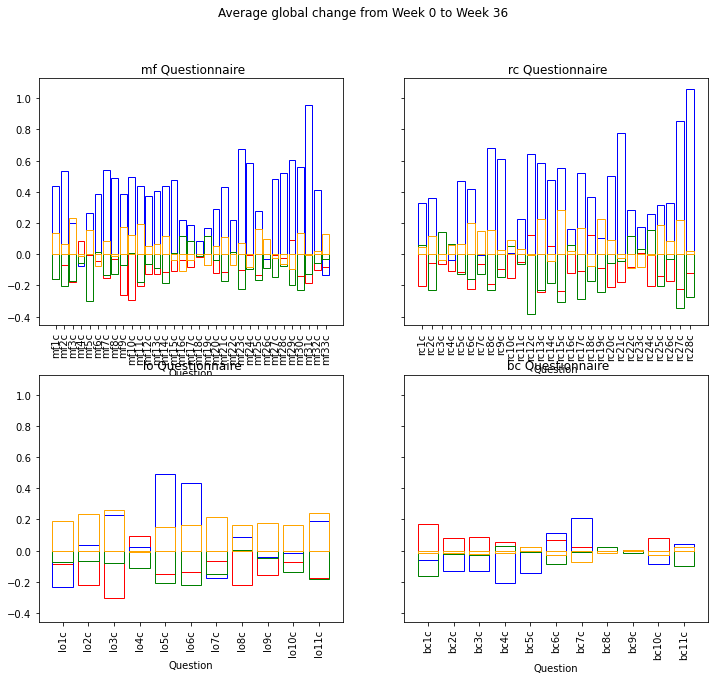

In [47]:
# now graph the difference between the global mean and the averages from each macrovariable class, colored by class 


timepoints = ['Week 0', 'Week '+which_week]

fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(12, 10), sharey=True, squeeze=False)
colors = ['red', 'blue', 'green', 'orange']

for test_type, ax in zip(['mf', 'rc', 'lo', 'bc'], axes.flat): 

    # get only the columns that contain the current test type 
    test_columns = [col for col in temp_df.columns if test_type in col]

    # get the global average change 
    global_mean= avgs_df.loc[:, test_columns].iloc[[0]].values[0]

    # for each macrovariable: 
    for i in range(1, len(avgs_df)) : #skip first row, which contains global avgs
        # get the mean for that macrovariable
        current_macrovar_mean = avgs_df.loc[:, test_columns].iloc[[i]].values[0]
        #subtract the global mean from the mean for the macrovariable 
        global_adj_macrovar_mean = current_macrovar_mean - global_mean
        
        # then add the values to a bar chart 
        ax.bar(test_columns, global_adj_macrovar_mean, edgecolor=colors[i-1], color="None" ) #manually making sure the same color is associated w same macrovar each time

    ax.set_xlabel("Question")
    ax.set_title(" {} Questionnaire".format(test_type))
    ax.set_xticklabels(labels=test_columns,rotation=90) 


# axes[0].set_ylabel("Change in Avg Scores")
# axes[2].set_ylabel("Change in Avg Scores")

fig.suptitle("Average global change from Week 0 to Week {}".format(which_week))


Text(0.5, 0.98, 'Global mean adjusted change from Week 0 to Week 36')

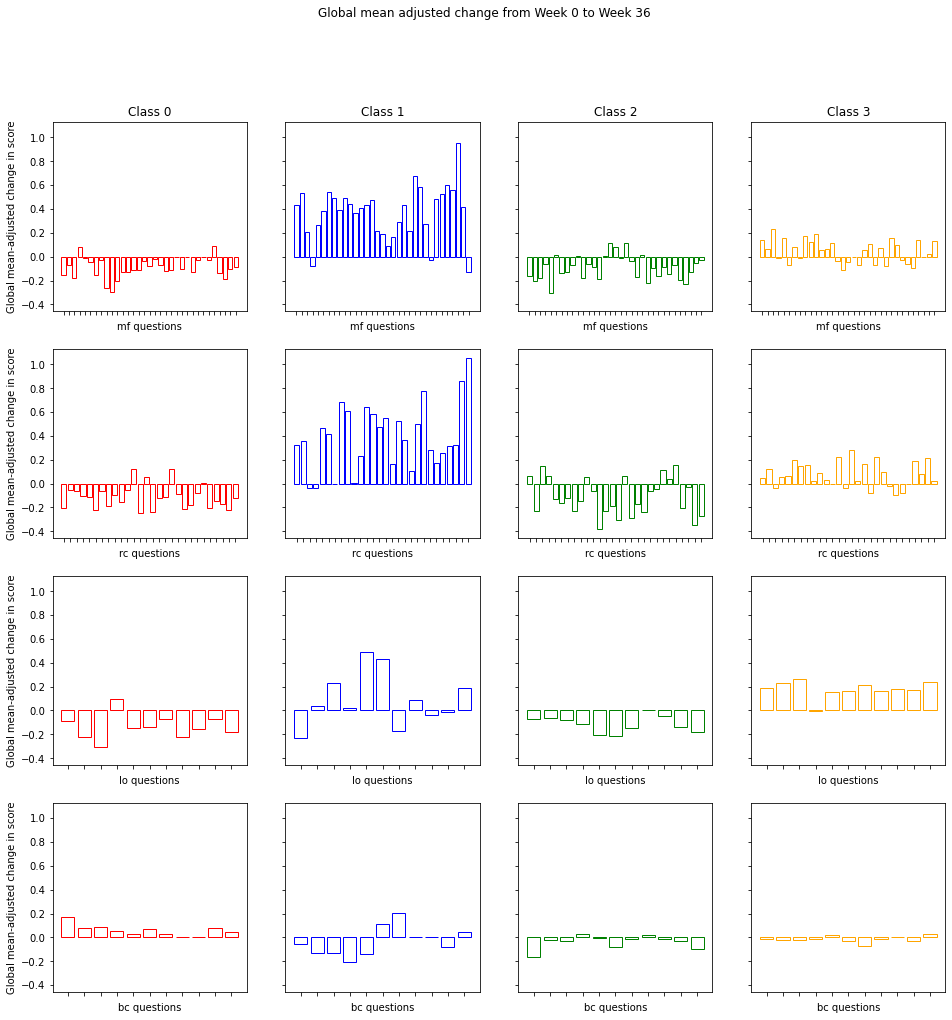

In [69]:
# now graph the difference between the global mean and the averages from each macrovariable class, colored by class 

timepoints = ['Week 0', 'Week '+which_week]

fig, axes = plt.subplots(nrows=4, ncols=4, figsize=(16, 16), sharey=True)
colors = ['red', 'blue', 'green', 'orange']

firstrow = True

# for each questionnaire type: 
for test_type, ax_row in zip(['mf', 'rc', 'lo', 'bc'], axes): 

    # get only the columns that contain the current test type 
    test_columns = [col for col in temp_df.columns if test_type in col]

    # get the global average change 
    global_mean= avgs_df.loc[:, test_columns].iloc[[0]].values[0]

    # for each macrovariable: 
    for i, ax in zip(range(len(avgs_df))[:-1], ax_row): 
        # get the mean for that macrovariable
        current_macrovar_mean = avgs_df.loc[:, test_columns].iloc[[i+1]].values[0]#skip first row, which contains global avgs
        #subtract the global mean from the mean for the macrovariable 
        global_adj_macrovar_mean = current_macrovar_mean - global_mean
        
        # then add the values to a bar chart 
        ax.bar(test_columns, global_adj_macrovar_mean, edgecolor=colors[i], color="None" ) #manually making sure the same color is associated w same macrovar each time

        ax.set_xlabel("{} questions".format(test_type))
        ax.set_xticklabels(labels=[]) # hide axis tick labels

        if firstrow: # set macrovar titles 
            ax_row[i].set_title("Class {}".format(i))


    firstrow=False
    ax_row[0].set_ylabel("Global mean-adjusted change in score")


# # axes[0].set_ylabel("Change in Avg Scores")
# # axes[2].set_ylabel("Change in Avg Scores")

fig.suptitle("Global mean adjusted change from Week 0 to Week {}".format(which_week))
